In [58]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [59]:
%%bash
cd .. && make clean && make

src/Ex3_2024.cpp:55:74: warning: unused parameter 't' [-Wunused-parameter]
   55 |         valarray<long double> get_f(const valarray<long double>& x, long double t) {
      |                                                                                 ^
1 warning generated.


In [60]:
config_name = 'lagrange2'
conf = load_conf(config_name)

In [61]:
tFin = 2 * 365 * 24 * 60 * 60
tFin

63072000

In [62]:
# Position Lagrange 2
G = 6.674e-11
d = 149.598023e9
ms = conf['m1']
mt = conf['m2']
xs = -mt * d / (mt + ms)
xt = ms * d / (mt + ms)
Omega = np.sqrt(G * ms / (d**2 * xt))
Omega2 = Omega**2

coefs = [
    Omega2,
    -2 * Omega2 * (xs+xt),
    Omega2 * ((xt + xs)**2 + 2 * xt * xs),
    -(G * (ms + mt) + 2 * Omega2 * xt * xs * (xt + xs)),
    2 * G * (ms * xt + mt * xs) + Omega2 * xt**2 * xs**2,
    -G * (ms * xt**2 + mt * xs**2)
]
roots = np.roots(coefs)
assert roots[2].imag == 0.0
L2x = roots[2].real

In [63]:
all_fixed = run_with_params(
    config_name,
    gen_variations({
        'nsteps': np.linspace(10000, 100000, 100),
        'adapt': ['false'],
        'tFin': [tFin],
    })
)
all_adapt = run_with_params(
    config_name,
    gen_variations({
        'tol': np.logspace(-5, -1, 100),
        'adapt': ['true'],
        'tFin': [tFin],
    }),
)

Running simulations... Done 100/100
Running simulations... Done 100/100


# Plots!

1981.0 63072000.0 63072000 True 0.1
100000.0


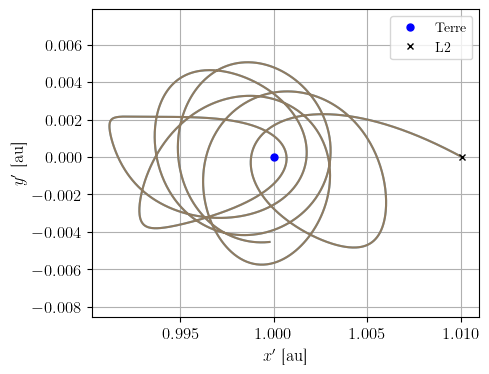

In [64]:
%matplotlib inline
# Do plots!
# plt.figure(figsize=(8, 8))

au = 1.495978707e11  # m / au

for i, (params, data) in enumerate(all_adapt):
    if i != len(all_adapt)-1: continue
    # if i != 0: continue
    t, x, y, ns = data[:,0], data[:,1] / au, data[:,2] / au, data[:,6]
    print(ns[-1], t[-1], tFin, t[-1] == tFin, params['tol'])
    line, = plt.plot(x, y, '-', markersize=5)

for i, (params, data) in enumerate(all_fixed):
    if i != len(all_fixed)-1: continue
    t, x, y, ns = data[:,0], data[:,1] / au, data[:,2] / au, data[:,6]
    print(ns[-1])
    line, = plt.plot(x, y, '-', markersize=5, alpha=0.5)

# plt.plot(xs/au, 0, 'o', color='red', label='Soleil', markersize=5, zorder=2)
plt.plot(xt/au, 0, 'o', color='blue', label='Terre', markersize=5, zorder=2)
plt.plot(L2x/au, 0, 'x', color='black', label='L2', markersize=5, zorder=2)

plt.xlabel(r"$x'$ [au]")
plt.ylabel(r"$y'$ [au]")
plt.axis('equal')
plt.legend()
plt.grid()

In [20]:
xfs_fixed = np.zeros(len(all_fixed))
yfs_fixed = np.zeros(len(all_fixed))
nsfs_fixed = np.zeros(len(all_fixed))
emec_error_fixed = np.zeros(len(all_fixed))
for i, (params, data) in enumerate(all_fixed):
    tf, xf, yf, nrj, nsf = data[-1,0], data[-1,1] / au, data[-1,2] / au, data[:,5], data[-1,6]
    xfs_fixed[i] = xf
    yfs_fixed[i] = yf
    nsfs_fixed[i] = nsf
    emec_error_fixed[i] = np.max(nrj) - np.min(nrj)

xfs_adapt = np.zeros(len(all_adapt))
yfs_adapt = np.zeros(len(all_adapt))
nsfs_adapt = np.zeros(len(all_adapt))
emec_error_adapt = np.zeros(len(all_adapt))
for i, (params, data) in enumerate(all_adapt):
    tf, xf, yf, nrj, nsf = data[-1,0], data[-1,1] / au, data[-1,2] / au, data[:,5], data[-1,6]
    xfs_adapt[i] = xf
    yfs_adapt[i] = yf
    nsfs_adapt[i] = nsf
    emec_error_adapt[i] = np.max(nrj) - np.min(nrj)

Converge in x to 0.999771677966905
Converge in y to -0.0045379850836094315


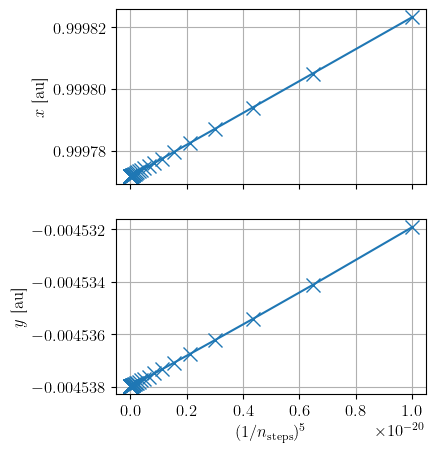

In [21]:
tmp = plt.subplots(nrows=2, sharex=True)
fig = tmp[0]
fig.set_size_inches(4, 5)
ax: list[plt.Axes] = tmp[1]

coefs = np.polyfit(nsfs_fixed**-5, xfs_fixed, 1)
fitfunc = np.poly1d(coefs)
print(f"Converge in x to {fitfunc(0)}")
ax[0].plot(nsfs_fixed**-5, xfs_fixed, 'x-')

coefs = np.polyfit(nsfs_fixed**-5, yfs_fixed, 1)
fitfunc = np.poly1d(coefs)
print(f"Converge in y to {fitfunc(0)}")
ax[1].plot(nsfs_fixed**-5, yfs_fixed, 'x-')

ax[1].set_xlabel(r'$(1/n_\textrm{steps})^5$')
ax[0].set_ylabel(r'$x$ [au]')
ax[1].set_ylabel(r'$y$ [au]')
ax[0].grid()
ax[1].grid()
plt.savefig(export_path + 'lagrange_convergence_fixed.pdf')
plt.show()

Converge in x to 0.999771677966905
Converge in y to -0.0045379850836094315


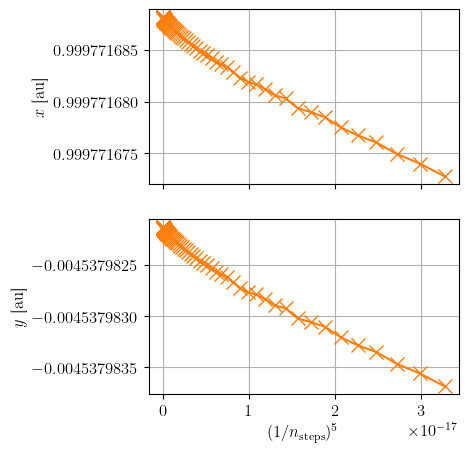

In [22]:
tmp = plt.subplots(nrows=2, sharex=True)
fig = tmp[0]
fig.set_size_inches(4, 5)
ax: list[plt.Axes] = tmp[1]

coefs = np.polyfit(nsfs_fixed**-5, xfs_fixed, 1)
fitfunc = np.poly1d(coefs)
print(f"Converge in x to {fitfunc(0)}")
ax[0].plot(nsfs_adapt**-5, xfs_adapt, 'x-', color='tab:orange')

coefs = np.polyfit(nsfs_fixed**-5, yfs_fixed, 1)
fitfunc = np.poly1d(coefs)
print(f"Converge in y to {fitfunc(0)}")
ax[1].plot(nsfs_adapt**-5, yfs_adapt, 'x-', color='tab:orange')

ax[1].set_xlabel(r'$(1/n_\textrm{steps})^5$')
ax[0].set_ylabel(r'$x$ [au]')
ax[1].set_ylabel(r'$y$ [au]')
ax[0].grid()
ax[1].grid()
plt.savefig(export_path + 'lagrange_convergence_adapt.pdf')
plt.show()

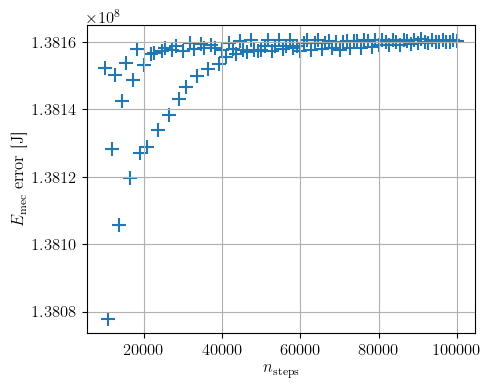

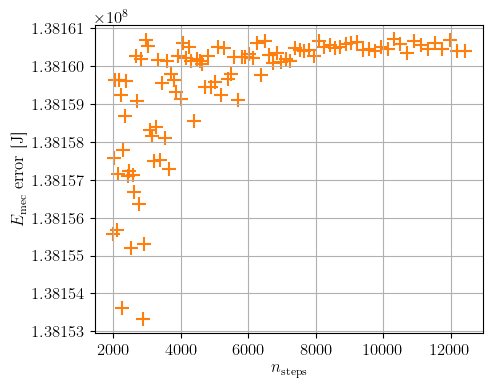

In [38]:
plt.scatter(nsfs_fixed, emec_error_fixed)
plt.xlabel(r'$n_\textrm{steps}$')
plt.ylabel(r'$E_\textrm{mec}$ error [J]')
plt.grid()
plt.savefig(export_path + 'lagrange_emec_error_fixed.pdf')
plt.show()

plt.scatter(nsfs_adapt, emec_error_adapt, color='tab:orange')
plt.xlabel(r'$n_\textrm{steps}$')
plt.ylabel(r'$E_\textrm{mec}$ error [J]')
plt.grid()
plt.savefig(export_path + 'lagrange_emec_error_adapt.pdf')
plt.show()

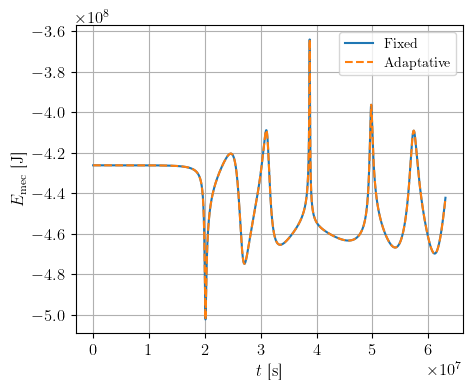

In [37]:
_, best_data_fixed = all_fixed[0]
_, best_data_adapt = all_adapt[-1]

t, emec = best_data_fixed[:,0], best_data_fixed[:,5]
plt.plot(t, emec, label='Fixed')
t, emec = best_data_adapt[:,0], best_data_adapt[:,5]
plt.plot(t, emec, '--', label='Adaptative')

plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$E_\textrm{mec}$ [J]')
plt.grid()
plt.legend()
# print(best_data_fixed[:,6][-1], best_data_adapt[:,6][-1])
plt.savefig(export_path + 'lagrange_emec.pdf')

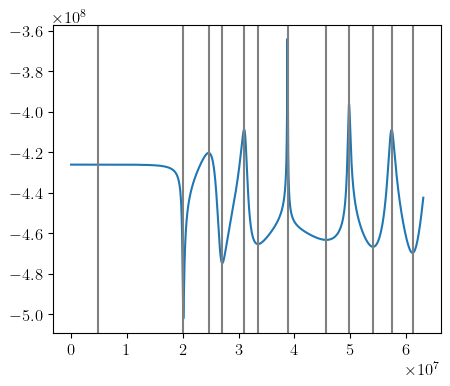

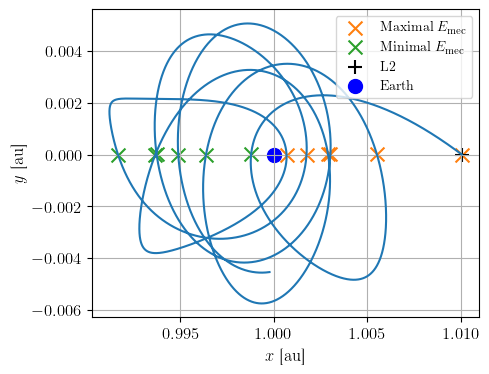

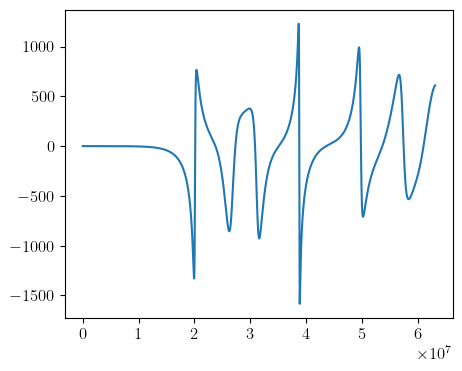

In [68]:
_, best_data_adapt = all_adapt[0]

t, x, y, vx, vy, emec = best_data_adapt[:,0], best_data_adapt[:,1]/au, best_data_adapt[:,2]/au, best_data_adapt[:,3], best_data_adapt[:,4], best_data_adapt[:,5]
mins = sc.signal.argrelmin(emec)[0]
maxs = sc.signal.argrelmax(emec)[0]
plt.plot(t, emec)
for i in (*mins, *maxs):
    plt.axvline(t[i])
plt.show()

plt.plot(x, y)
plt.scatter(x[maxs], y[maxs], color='tab:orange', marker='x', label=r'Maximal $E_\textrm{mec}$')
plt.scatter(x[mins], y[mins], color='tab:green', marker='x', label=r'Minimal $E_\textrm{mec}$')
plt.scatter(L2x / au, 0, marker='+', color='k', label='L2')
plt.scatter(xt / au, 0, marker='o', color='blue', label='Earth')

plt.xlabel(r'$x$ [au]')
plt.ylabel(r'$y$ [au]')
plt.grid()
plt.legend()
plt.savefig(export_path + 'lagrange_max_mins_energy.pdf')
plt.show()

plt.plot(t, vx)

# dt

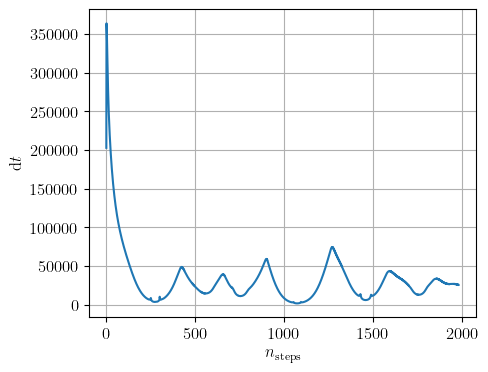

In [26]:
for i, (params, data) in enumerate(all_adapt):
    if not (i == len(all_adapt)-1): continue
    nstep, dt = data[:,6], data[:,7]
    plt.plot(nstep, dt)

plt.xlabel(r'$n_\textrm{steps}$')
plt.ylabel(r'd$t$')
plt.grid()

# Visualise better

In [18]:
%matplotlib qt
import matplotlib.animation as mpla
mpl.rcParams["text.usetex"] = False
plt.figure(figsize=(8, 8))

params, data = next(iter(reversed(all_fixed.values())))
t, xp, yp, ns = data[:,0], data[:,1], data[:,2], data[:,6]
x = xp * np.cos(Omega * t) - yp * np.sin(Omega * t)
y = xp * np.sin(Omega * t) + yp * np.cos(Omega * t)
line, = plt.plot(x[0], y[0], 'x-', markersize=5)
size = len(t)

terre, = plt.plot(xt, 0, 'o', color='blue', label='Terre', markersize=5, zorder=2)
soleil, = plt.plot(xs, 0, 'o', color='red', label='Soleil', markersize=5, zorder=2)
lagrange2, = plt.plot(L2x, 0, 'x', color='black', label='L2', markersize=5, zorder=2)

def animate(i) -> Any:
    idx = i % len(t)
    line.set_data(x[max(0, idx-5):idx], y[max(0, idx-5):idx])
    terre.set_data([xt * np.cos(Omega * t[idx])], [xt * np.sin(Omega * t[idx])])
    soleil.set_data([xs * np.cos(Omega * t[idx])], [xs * np.sin(Omega * t[idx])])
    lagrange2.set_data([L2x * np.cos(Omega * t[idx])], [L2x * np.sin(Omega * t[idx])])
    # plt.tight_layout()

def animatebis(i) -> Any:
    idx = i % len(t)
    line.set_data(xp[max(0, idx-5):idx], yp[max(0, idx-5):idx])

anim = mpla.FuncAnimation(plt.gcf(), animatebis, interval=20, cache_frame_data=True, frames=1000)

plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')
plt.xlim(np.min(xp)*1.1, np.max(xp)*1.1)
plt.ylim(np.min(yp)*1.1, np.max(yp)*1.1)
plt.axis('equal')
# plt.legend()
plt.grid()